In [145]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import scipy.stats as st
sns.set_style("whitegrid")

## Specify the sampling distirubtion: Mixture of Gaussians

In [230]:
n = 1000  # number of samples

norm_params = np.array([[5, 1],
                        [1, 1.3],
                        [9, 1.3]])
n_components = norm_params.shape[0]
weights = np.ones(n_components, dtype=np.float64) / 3.0
mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
X_raw = np.fromiter((st.norm.rvs(*(norm_params[i])) for i in mixture_idx), dtype=np.float64).reshape(n ,1)
mu =  X_raw.mean()
sd = X_raw.std()
X = (X_raw -mu) / sd

## Specify the normalising flow base distribution

In [235]:
base_dist = dist.Normal(torch.zeros(1), torch.ones(1))
spline_transform = T.Spline(1, count_bins=100)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

## Train

In [236]:
%%time
smoke_test = False
steps = 1 if smoke_test else 1001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)
for step in range(steps):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.144205331802368
step: 200, loss: 1.2552783489227295
step: 400, loss: 1.2160905599594116
step: 600, loss: 1.2066843509674072
step: 800, loss: 1.2092993259429932
step: 1000, loss: 1.2079918384552002
Wall time: 4.25 s


## Plot results

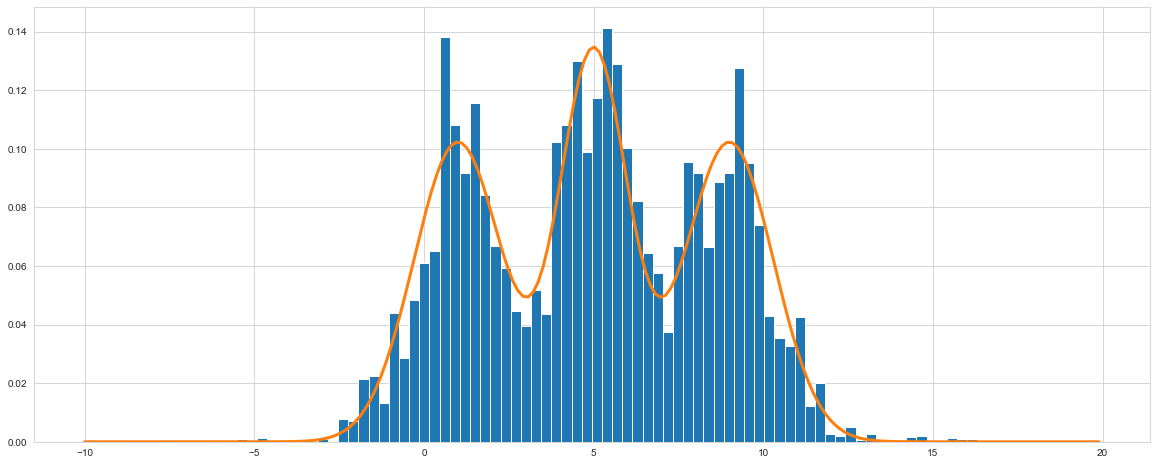

In [244]:
X_flow = flow_dist.sample(torch.Size([100000,])).detach().numpy() * sd + mu
fig, ax = plt.subplots(figsize=(20,8))
ax.hist(X_flow.ravel(), density=True, bins=100)
xs = np.linspace(X_flow.min(), X_flow.max(), 200)
ys = np.zeros_like(xs)

for (l, s), w in zip(norm_params, weights):
    ys += st.norm.pdf(xs, loc=l, scale=s) * w

plt.plot(xs, ys, lw=3)
plt.show()